In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time 
from getpass import getpass
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModel, get_linear_schedule_with_warmup, logging
logging.set_verbosity_error()

In [2]:
model_name='ai-forever/ruElectra-small'

In [3]:
data_path = '/mnt/d/DataSets/Toxic Russian Comments/dataset.txt'

rows = []
with open(data_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        labels, text = line.split(" ", 1)
        rows.append((labels, text))

df = pd.DataFrame(rows, columns=["labels_raw", "text"])
df.head(10)

,labels_raw,text
0,__label__INSULT,скотина! что сказать
1,__label__NORMAL,я сегодня проезжала по рабочей и между домами ...
2,__label__NORMAL,очередной лохотрон. зачем придумывать очередно...
3,__label__NORMAL,"ретро дежавю ... сложно понять чужое сердце , ..."
4,__label__NORMAL,а когда мы статус агрогородка получили?
5,__label__NORMAL,2 августа поздно вечером нашли вот такую потер...
6,__label__NORMAL,вчера надыбала новые стикеры #u2a94ec7fabs#
7,"__label__INSULT,__label__THREAT",заколоть этого плешивого урода что бы крякнул ...
8,__label__NORMAL,а еще на стоянке никто не проверяет безопаснос...
9,__label__NORMAL,"красота..!! если есть, что показать??!! почему..."


In [4]:
def split_labels(labels_raw): 
    labels = labels_raw.split(',')
    labels = [lab.replace('__label__', '') for lab in labels]
    return set(labels)

df['labels'] = df['labels_raw'].apply(split_labels)

df = df.drop('labels_raw', axis=1)
df.head(10)

,text,labels
0,скотина! что сказать,{INSULT}
1,я сегодня проезжала по рабочей и между домами ...,{NORMAL}
2,очередной лохотрон. зачем придумывать очередно...,{NORMAL}
3,"ретро дежавю ... сложно понять чужое сердце , ...",{NORMAL}
4,а когда мы статус агрогородка получили?,{NORMAL}
5,2 августа поздно вечером нашли вот такую потер...,{NORMAL}
6,вчера надыбала новые стикеры #u2a94ec7fabs#,{NORMAL}
7,заколоть этого плешивого урода что бы крякнул ...,"{THREAT, INSULT}"
8,а еще на стоянке никто не проверяет безопаснос...,{NORMAL}
9,"красота..!! если есть, что показать??!! почему...",{NORMAL}


In [5]:
label_names = ['NORMAL', 'INSULT', 'OBSCENITY', 'THREAT']

for label in label_names: 
    df[label] = df['labels'].apply(lambda x: 1 if label in x else 0)

df.head(10)

,text,labels,NORMAL,INSULT,OBSCENITY,THREAT
0,скотина! что сказать,{INSULT},0,1,0,0
1,я сегодня проезжала по рабочей и между домами ...,{NORMAL},1,0,0,0
2,очередной лохотрон. зачем придумывать очередно...,{NORMAL},1,0,0,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",{NORMAL},1,0,0,0
4,а когда мы статус агрогородка получили?,{NORMAL},1,0,0,0
5,2 августа поздно вечером нашли вот такую потер...,{NORMAL},1,0,0,0
6,вчера надыбала новые стикеры #u2a94ec7fabs#,{NORMAL},1,0,0,0
7,заколоть этого плешивого урода что бы крякнул ...,"{THREAT, INSULT}",0,1,0,1
8,а еще на стоянке никто не проверяет безопаснос...,{NORMAL},1,0,0,0
9,"красота..!! если есть, что показать??!! почему...",{NORMAL},1,0,0,0


In [6]:
df = df.drop('labels', axis=1)
df.head(10)

,text,NORMAL,INSULT,OBSCENITY,THREAT
0,скотина! что сказать,0,1,0,0
1,я сегодня проезжала по рабочей и между домами ...,1,0,0,0
2,очередной лохотрон. зачем придумывать очередно...,1,0,0,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",1,0,0,0
4,а когда мы статус агрогородка получили?,1,0,0,0
5,2 августа поздно вечером нашли вот такую потер...,1,0,0,0
6,вчера надыбала новые стикеры #u2a94ec7fabs#,1,0,0,0
7,заколоть этого плешивого урода что бы крякнул ...,0,1,0,1
8,а еще на стоянке никто не проверяет безопаснос...,1,0,0,0
9,"красота..!! если есть, что показать??!! почему...",1,0,0,0


In [7]:
df = df.drop('NORMAL', axis=1)
df.head()

,text,INSULT,OBSCENITY,THREAT
0,скотина! что сказать,1,0,0
1,я сегодня проезжала по рабочей и между домами ...,0,0,0
2,очередной лохотрон. зачем придумывать очередно...,0,0,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",0,0,0
4,а когда мы статус агрогородка получили?,0,0,0


In [8]:
print(df.isnull().sum())

text         0
INSULT       0
OBSCENITY    0
THREAT       0
dtype: int64


In [9]:
df['combo'] = df["INSULT"] * 1 + df["OBSCENITY"] * 2 + df["THREAT"] * 4
df.head(10)

,text,INSULT,OBSCENITY,THREAT,combo
0,скотина! что сказать,1,0,0,1
1,я сегодня проезжала по рабочей и между домами ...,0,0,0,0
2,очередной лохотрон. зачем придумывать очередно...,0,0,0,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",0,0,0,0
4,а когда мы статус агрогородка получили?,0,0,0,0
5,2 августа поздно вечером нашли вот такую потер...,0,0,0,0
6,вчера надыбала новые стикеры #u2a94ec7fabs#,0,0,0,0
7,заколоть этого плешивого урода что бы крякнул ...,1,0,1,5
8,а еще на стоянке никто не проверяет безопаснос...,0,0,0,0
9,"красота..!! если есть, что показать??!! почему...",0,0,0,0


In [10]:
train_val, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['combo'])
train_df, val_df = train_test_split(train_val, test_size=0.1, random_state=42, stratify=train_val['combo'])

In [11]:
test_df.tail(10)

,text,INSULT,OBSCENITY,THREAT,combo
167907,какой сказачный терем♥♥♥👍👍👍👍👍,0,0,0,0
195031,"вы скидываете сюда эти скриншоты, убеждая люде...",0,0,0,0
70848,"остановку сделали бы на ильича крытую, для удо...",0,0,0,0
120760,тебя будут судить мыкола,0,0,0,0
124654,"0,5литровая баночка 200р стоит в таганроге. та...",0,0,0,0
181287,"такой милый, сладкий рыбачок! дай бог ему пойм...",0,0,0,0
57467,где ты било досехпор?,0,0,0,0
24215,23616 я там покупала недорого,0,0,0,0
83466,а мы шурупом на работе открывали...проблемно.....,0,0,0,0
143873,"ужас, у нас дома бассейн.не разрешаю ходить в ...",0,0,0,0


In [12]:
train_df = train_df.drop('combo', axis=1)
val_df = val_df.drop('combo', axis=1)
test_df = test_df.drop('combo', axis=1)

In [13]:
labels = ['INSULT', 'OBSCENITY', 'THREAT']

class ToxicDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, max_length=256):
        self.texts = df["text"].tolist()
        self.labels = df[labels].astype(np.float32).values
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx: int):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_length,
            padding=False,
            return_tensors=None
        )
        item = {k: torch.tensor(v, dtype=torch.long) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset = ToxicDataset(train_df, tokenizer, max_length=256)
val_dataset = ToxicDataset(val_df, tokenizer, max_length=256)
test_dataset = ToxicDataset(test_df, tokenizer, max_length=256)

In [15]:
batch_size = 32
num_workers = 6

collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=num_workers, 
    collate_fn=collator, 
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=num_workers, 
    collate_fn=collator, 
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=num_workers, 
    collate_fn=collator, 
    pin_memory=True
)

In [16]:
class ElectraMultiLabel(nn.Module):
    def __init__(self, model_name, num_labels = 3, dropout = 0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        out = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        cls = out.last_hidden_state[:, 0]
        logits = self.classifier(self.dropout(cls))
        return logits

In [17]:
def compute_pos_weight(train_df):
    y = train_df[labels].values.astype("float32")
    pos = y.sum(axis=0)
    neg = y.shape[0] - pos
    pos_weight = neg / (pos + 1e-6)
    return torch.tensor(pos_weight, dtype=torch.float32)

In [18]:
def train_model(
    model,
    train_loader,
    val_loader,
    loss_function,
    optimizer,
    device,
    epochs=20,
    scheduler=None,
    save_path=None,
    save_freq=1,
    grad_clip=1.0,
    scheduler_step_per_batch=True,
    amp=True
):
    train_losses = []
    val_losses = []

    model_state_dict = {"optimizer": None, "model": None}
    scaler = torch.cuda.amp.GradScaler(enabled=(amp and device.startswith("cuda")))

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0

        train_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [train]")
        for batch in train_tqdm:

            batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
            labels = batch.pop("labels")

            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(amp and device.startswith("cuda"))):
                logits = model(**batch)
                loss = loss_function(logits, labels)

            scaler.scale(loss).backward()

            if grad_clip is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            scaler.step(optimizer)
            scaler.update()

            if scheduler is not None and scheduler_step_per_batch:
                scheduler.step()

            epoch_train_loss += loss.item()
            train_tqdm.set_postfix(loss=f"{loss.item():.4f}")

        epoch_train_loss /= max(1, len(train_loader))
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
                labels = batch.pop("labels")

                with torch.cuda.amp.autocast(enabled=(amp and device.startswith("cuda"))):
                    logits = model(**batch)
                    loss = loss_function(logits, labels)

                epoch_val_loss += loss.item()

        epoch_val_loss /= max(1, len(val_loader))
        val_losses.append(epoch_val_loss)

        if scheduler is not None and not scheduler_step_per_batch:
            scheduler.step(epoch_val_loss)


        if save_path is not None and ((epoch + 1) % save_freq == 0):
            model_state_dict["optimizer"] = optimizer.state_dict()
            model_state_dict["model"] = model.state_dict()
            torch.save(model_state_dict, f"{save_path}/Epoch[{epoch+1}].tar")

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}"
        )

    total_time = time.time() - start_time
    print(f"\nОбщее время обучения: {total_time:.2f} секунд")

    return train_losses, val_losses

In [19]:
def _multilabel_metrics(y_true, y_pred, eps = 1e-9):
    per_label = []
    for k in range(y_true.shape[1]):
        tp = ((y_true[:, k] == 1) & (y_pred[:, k] == 1)).sum()
        fp = ((y_true[:, k] == 0) & (y_pred[:, k] == 1)).sum()
        fn = ((y_true[:, k] == 1) & (y_pred[:, k] == 0)).sum()

        precision = tp / (tp + fp + eps)
        recall    = tp / (tp + fn + eps)
        f1        = 2 * precision * recall / (precision + recall + eps)
        support   = (y_true[:, k] == 1).sum()

        per_label.append({
            "precision": float(precision),
            "recall": float(recall),
            "f1": float(f1),
            "support": int(support),
            "tp": int(tp),
            "fp": int(fp),
            "fn": int(fn),
        })

    macro_f1 = float(np.mean([m["f1"] for m in per_label]))
    return per_label, macro_f1

In [20]:
def test_model(
    model,
    test_loader,
    device,
    loss_function=None, 
    threshold=0.5,
    amp=True,
    label_names=labels,
    return_arrays=False
):
    model.eval()

    all_probs = []
    all_targets = []
    total_loss = 0.0

    use_amp = amp and str(device).startswith("cuda")

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing [test]"):
            batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
            y = batch.pop("labels")

            with torch.cuda.amp.autocast(enabled=use_amp):
                logits = model(**batch)
                if loss_function is not None:
                    loss = loss_function(logits, y)
                    total_loss += loss.item()

            probs = torch.sigmoid(logits).detach().cpu().numpy()
            all_probs.append(probs)
            all_targets.append(y.detach().cpu().numpy())

    probs = np.concatenate(all_probs, axis=0)
    y_true = np.concatenate(all_targets, axis=0).astype(int)
    y_pred = (probs >= float(threshold)).astype(int)

    per_label, macro_f1 = _multilabel_metrics(y_true, y_pred)

    if loss_function is not None:
        test_loss = total_loss / max(1, len(test_loader))
        print(f"Test Loss: {test_loss:.6f}")

    print(f"Threshold: {threshold}")
    for name, m in zip(label_names, per_label):
        print(
            f"{name:10s} | "
            f"F1: {m['f1']:.4f} | P: {m['precision']:.4f} | R: {m['recall']:.4f} | "
            f"support: {m['support']} | tp/fp/fn: {m['tp']}/{m['fp']}/{m['fn']}"
        )
    print(f"Macro F1: {macro_f1:.4f}")

    pred_normal = (y_pred.sum(axis=1) == 0).mean()
    true_normal = (y_true.sum(axis=1) == 0).mean()
    print(f"Normal (true): {true_normal:.4f} | Normal (pred): {pred_normal:.4f}")

    if return_arrays:
        return {
            "probs": probs,
            "y_true": y_true,
            "y_pred": y_pred,
            "macro_f1": macro_f1,
            "per_label": per_label,
        }

In [21]:
device = 'cuda'

BfTB = ElectraMultiLabel(
    model_name=model_name,
    num_labels=3,
    dropout=0.1
).to(device)

pos_weight = compute_pos_weight(train_df).to(device)
tox_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = AdamW(
    BfTB.parameters(),
    lr=2e-5,
    weight_decay=0.01
)

epochs = 3
total_steps = epochs * len(train_loader)
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

save_path = "runs/BfTB/"

Loading weights: 100%|█████| 199/199 [00:00<00:00, 529.99it/s, Materializing param=encoder.layer.11.output.dense.weight]


In [23]:
train_losses, val_losses = train_model(
    model=BfTB,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=tox_loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    scheduler=scheduler,
    save_path=save_path,
    save_freq=1,
    grad_clip=1.0,
    scheduler_step_per_batch=True,
    amp=True
)

/tmp/ipykernel_2937/1339352863.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(amp and device.startswith("cuda")))
Epoch 1/3 [train]:   0%|                                                                       | 0/6285 [00:00<?, ?it/s]/tmp/ipykernel_2937/1339352863.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(amp and device.startswith("cuda"))):
Epoch 1/3 [train]: 100%|███████████████████████████████████████████████| 6285/6285 [08:46<00:00, 11.93it/s, loss=0.0996]
/tmp/ipykernel_2937/1339352863.py:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(amp and device.startswith("cuda"))):


Epoch [1/3] | Train Loss: 0.592728 | Val Loss: 0.390292


Epoch 2/3 [train]: 100%|███████████████████████████████████████████████| 6285/6285 [08:56<00:00, 11.72it/s, loss=0.9669]


Epoch [2/3] | Train Loss: 0.359867 | Val Loss: 0.331854


Epoch 3/3 [train]: 100%|███████████████████████████████████████████████| 6285/6285 [08:49<00:00, 11.87it/s, loss=0.0534]


Epoch [3/3] | Train Loss: 0.317110 | Val Loss: 0.342169

Общее время обучения: 1643.44 секунд


In [24]:
def draw_train_val_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Val Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

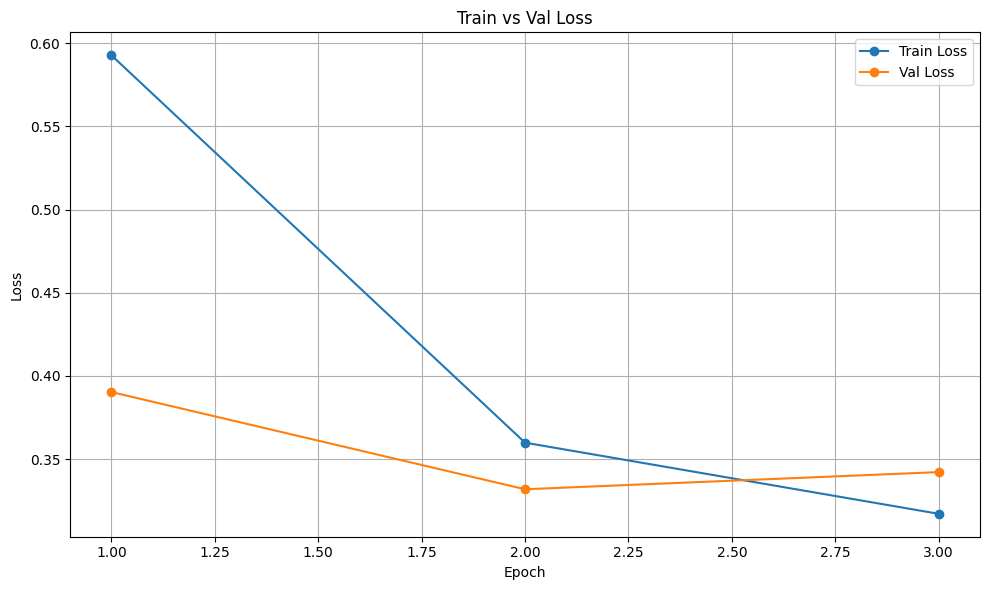

In [25]:
draw_train_val_loss(train_losses, val_losses)

In [22]:
model_data = torch.load(f'{save_path}/Epoch[3].tar')

BfTB.load_state_dict(model_data['model'])

<All keys matched successfully>

In [23]:
res = test_model(
    model=BfTB,
    test_loader=test_loader,
    device=device,
    loss_function=tox_loss_fn,
    threshold=0.5,
    amp=True,
    label_names=("INSULT", "OBSCENITY", "THREAT"),
    return_arrays=True
)

Testing [test]:   0%|                                                                           | 0/776 [00:00<?, ?it/s]/tmp/ipykernel_601/3413856657.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Testing [test]: 100%|█████████████████████████████████████████████████████████████████| 776/776 [00:22<00:00, 33.95it/s]

Test Loss: 0.301696
Threshold: 0.5
INSULT     | F1: 0.8675 | P: 0.7996 | R: 0.9479 | support: 3684 | tp/fp/fn: 3492/875/192
OBSCENITY  | F1: 0.7482 | P: 0.6788 | R: 0.8333 | support: 426 | tp/fp/fn: 355/168/71
THREAT     | F1: 0.8064 | P: 0.7070 | R: 0.9385 | support: 1203 | tp/fp/fn: 1129/468/74
Macro F1: 0.8074
Normal (true): 0.8203 | Normal (pred): 0.7991


In [37]:
def predict_toxicity(
    model,
    tokenizer,
    text,
    device,
    threshold=0.5,
    max_length=256,
    amp=True
):
    model.eval()
    use_amp = amp and str(device).startswith("cuda")

    with torch.no_grad():
        enc = tokenizer(
            text,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        enc = {k: v.to(device, non_blocking=True) for k, v in enc.items()}
    
        with torch.amp.autocast("cuda", enabled=use_amp):
            logits = model(**enc)
            probs = torch.sigmoid(logits)[0]

    probs = probs.detach().cpu()
    pred = (probs >= float(threshold)).to(torch.int32)

    result = {
        "text": text,
        "probs": {labels[i]: float(probs[i].item()) for i in range(3)},
        "pred":  {labels[i]: int(pred[i].item())  for i in range(3)},
    }
    result["normal"] = int(sum(result["pred"].values()) == 0)
    return result

In [77]:
while True:
    print("-" * 80)
    text = getpass('Ведите текст для проверки:\n').strip()
    # text = input('Ведите текст для проверки:\n').strip()
    if text in ('stop', 'q'):
        break

    result = predict_toxicity(
        model=BfTB,
        tokenizer=tokenizer,
        text=text,
        device=device,
        threshold=0.5,
        max_length=256,
        amp=True
    )

    probs = result["probs"]
    flags = [k for k,v in result["pred"].items() if v == 1]
    flags = flags if flags else ["NORMAL"]

    print("\npred:", ", ".join(flags))
    print("probs:", f"INSULT={probs['INSULT']:.3f} | OBSCENITY={probs['OBSCENITY']:.3f} | THREAT={probs['THREAT']:.3f}\n")

--------------------------------------------------------------------------------


Ведите текст для проверки:
 ········



pred: NORMAL
probs: INSULT=0.007 | OBSCENITY=0.010 | THREAT=0.008

--------------------------------------------------------------------------------


Ведите текст для проверки:
 ········



pred: NORMAL
probs: INSULT=0.332 | OBSCENITY=0.052 | THREAT=0.016

--------------------------------------------------------------------------------


Ведите текст для проверки:
 ········



pred: THREAT
probs: INSULT=0.075 | OBSCENITY=0.120 | THREAT=0.984

--------------------------------------------------------------------------------


Ведите текст для проверки:
 ········



pred: OBSCENITY
probs: INSULT=0.441 | OBSCENITY=0.996 | THREAT=0.382

--------------------------------------------------------------------------------


Ведите текст для проверки:
 ········



pred: INSULT
probs: INSULT=0.989 | OBSCENITY=0.042 | THREAT=0.079

--------------------------------------------------------------------------------


Ведите текст для проверки:
 ········
